IMPORTACION DE LIBRERIAS

In [ ]:
#Instalacion manual de Turner
!pip install -q -U keras-tuner

In [ ]:
#Importacion de Turner
import keras_tuner as kt

In [ ]:
#Importacion y version de Tensorflow
import tensorflow as tf

tf.__version__

'2.18.0'

In [ ]:
#Importacion y version de Keras
from tensorflow import keras

keras.__version__

'3.8.0'

IMPORTACION DE BASE DE DATOS DEL MNIST

In [ ]:
#Importacion datasets total del mnist
from tensorflow.keras import datasets

In [ ]:
mnist = datasets.mnist

In [ ]:
#Extraccion de datos en 2 grupos (ENTRENAMIENTO Y TEST)
(image_train, label_train), (image_test1, label_test1) = mnist.load_data()

from sklearn.model_selection import train_test_split

# DIVISONDE DATOS  DE TESTEO EN TESTEO Y VALIDACION
image_test, image_val, label_test, label_val = train_test_split(image_test1, label_test1, test_size=0.5, random_state=42)


In [ ]:
x= len(image_train)
y = len(image_test)
z = len(image_val)

print(x)
print(y)
print(z)


60000
5000
5000


NORMLIZACION DE DATOS Y ETIQUETAS

In [ ]:
# NORMALIZACION DE DATOS (VALORES ENTRE 0 Y 1) primer intento
image_train_prep1 = image_train.reshape((60000, 28*28))
image_train_prep2 = image_train_prep1.astype('float32') / 255.0

image_test_prep1 = image_test.reshape((5000, 28*28))
image_test_prep2 = image_test_prep1.astype('float32') / 255.0

image_val_prep1 = image_val.reshape((5000, 28*28))
image_val_prep2 = image_val_prep1.astype('float32') / 255.0

In [ ]:
#Categorizacion de etiqutas
from tensorflow.keras.utils import to_categorical

# NORMALIZACION Y CLASIFICAR LAS ETIQUETAS
label_train_prep = to_categorical(label_train)
label_test_prep = to_categorical(label_test)
label_val_prep = to_categorical(label_val)

In [ ]:
label_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [ ]:
label_train_prep

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

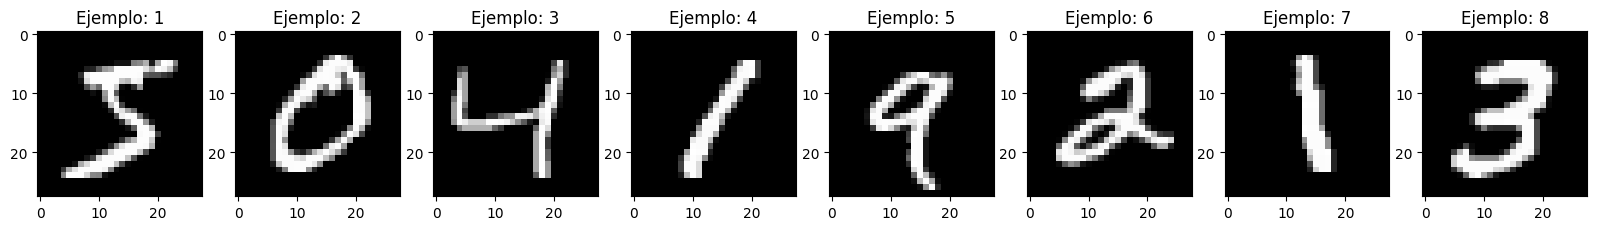

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# Visualizacion de los primeros 8 ejemplos de nuestro conjunto de datos de entrenamiento
plt.figure(figsize=(20, 4))

for index, digit in zip(range(1, 9), image_train[:8]):
    plt.subplot(1, 8, index)
    plt.imshow(np.reshape(digit, (28,28)), cmap=plt.cm.gray)
    plt.title('Ejemplo: ' + str(index))
plt.show()

In [ ]:
#Codigo auxiliar para eliminar la carpeta test_dir

import shutil
import os

# Define a list of folder names to delete
folders_to_delete = ['test_dir', 'another_folder_to_remove']

# Iterate through the list and remove each folder
for folder_name in folders_to_delete:
  if os.path.exists(folder_name):
    shutil.rmtree(folder_name)
    print(f"Folder '{folder_name}' deleted.")
  else:
    print(f"Folder '{folder_name}' not found.")


Folder 'test_dir' deleted.
Folder 'another_folder_to_remove' not found.


PREPARACION PARA CALCULAR LA PRIMERA CAPA DE LA RED

In [ ]:
def model_builder(hp):

    # Definición del modelo
    model = keras.Sequential()
    model.add(keras.Input(shape=(784,)))

    # Tunning del número de neuronas de la primera hidden layer
    # Seleccionamos el valor optimo entre 32 y 512
    hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
    model.add(keras.layers.Dense(units = hp_units, activation='relu' ))

    # Tunning del ratio de aprendizaje para el algoritmo de optimizacion
    # Seleccionamos el valor optimo entre [0.01, 0.001, 0.0001]
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate = hp_learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=['accuracy'])

    return model

In [ ]:
tuner = kt.Hyperband(
    model_builder,
    objective = 'val_accuracy',
    max_epochs = 10,
    factor = 3,
    directory = 'test_dir',
    project_name = 'hp_tuning',
)

In [ ]:
# Ejecución del tuner para la búsqueda de hiperparámetros
tuner.search(
    image_train_prep2,
    label_train,
    epochs = 5,
    validation_data = (image_test_prep2, label_test)
)

Trial 30 Complete [00h 01m 24s]
val_accuracy: 0.928600013256073

Best val_accuracy So Far: 0.9308000206947327
Total elapsed time: 00h 27m 40s


In [ ]:
# Obtención de los hiperparámetros óptimos
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Units:", best_hps.get('units'))
print("Learning rate:", best_hps.get('learning_rate'))

Units: 160
Learning rate: 0.001


In [ ]:
model = tuner.hypermodel.build(best_hps)

history = model.fit(
    image_train_prep2,
    label_train,
    epochs = 10,
    validation_data = (image_test_prep2, label_test)
)

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7836 - loss: 1.0928 - val_accuracy: 0.9158 - val_loss: 0.3089
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.9147 - loss: 0.3108 - val_accuracy: 0.9242 - val_loss: 0.2777
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.9211 - loss: 0.2889 - val_accuracy: 0.9240 - val_loss: 0.2713
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9227 - loss: 0.2784 - val_accuracy: 0.9260 - val_loss: 0.2706
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9250 - loss: 0.2655 - val_accuracy: 0.9272 - val_loss: 0.2675
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9283 - loss: 0.2598 - val_accuracy: 0.9284 - val_loss: 0.2597
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9300 - loss: 0.2491 - val_accuracy: 0.9280 - val_loss: 0.2653
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9315 - loss: 0.

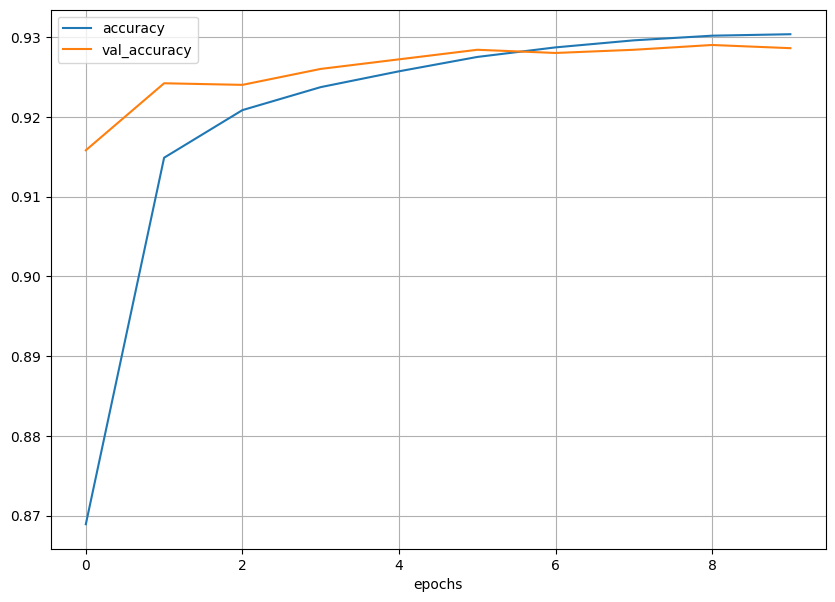

In [ ]:
import pandas as pd

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize=(10, 7))
plt.grid(True)
plt.xlabel("epochs")
plt.show()

PREPARACION DE RED NERURONAL

In [ ]:
from tensorflow.keras import models
from tensorflow.keras import layers

input_shape() = representa el tipo de dato que entrara en la red

In [ ]:
network = models.Sequential()

network.add(layers.Dense(448, activation='relu', input_shape=(28*28,)))
network.add(layers.Dense(224, activation='relu'))
network.add(layers.Dense(10, activation='softmax'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras import optimizers

opt_func = optimizers.Adam(learning_rate= 0.001)

In [ ]:
network.compile(
    optimizer=opt_func,
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy', 'Precision']
)

In [ ]:
history = network.fit(
    image_train_prep2,  # Usar imagenes aplanadas de 2D a array
    label_train_prep, # Usar etiquetas ya categorizadas
    epochs=108,
    batch_size=540,
    validation_data=(image_val_prep2, label_val_prep)
)

Epoch 1/108


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


111/112 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - Precision: 0.9211 - accuracy: 0.8033 - loss: 0.7180

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:666: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


112/112 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - Precision: 0.9215 - accuracy: 0.8049 - loss: 0.7120 - val_Precision: 0.9535 - val_accuracy: 0.9386 - val_loss: 0.2140
Epoch 2/108
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - Precision: 0.9655 - accuracy: 0.9570 - loss: 0.1497 - val_Precision: 0.9717 - val_accuracy: 0.9648 - val_loss: 0.1186
Epoch 3/108
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - Precision: 0.9779 - accuracy: 0.9726 - loss: 0.0953 - val_Precision: 0.9728 - val_accuracy: 0.9686 - val_loss: 0.0999
Epoch 4/108
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - Precision: 0.9827 - accuracy: 0.9786 - loss: 0.0720 - val_Precision: 0.9755 - val_accuracy: 0.9718 - val_loss: 0.0837
Epoch 5/108
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - Precision: 0.9892 - accuracy: 0.9868 - loss: 0.0462 - val_Precision: 0.9757 - val_accuracy: 0.9724 - val_loss: 0.0827
Epoch 6/108
112/112 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - Precision: 0.9919 - accuracy: 0.9900 - loss: 0.0342 - val_Precision: 0.9817 - val_accu

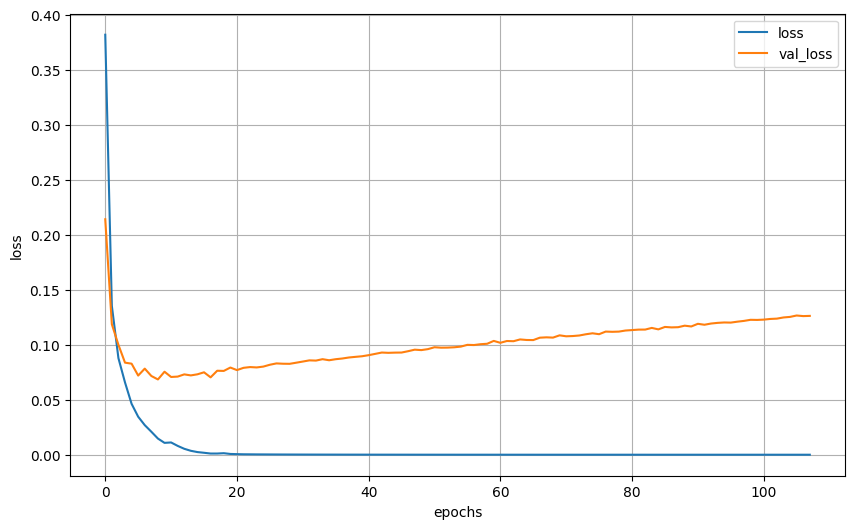

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['loss', 'val_loss']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

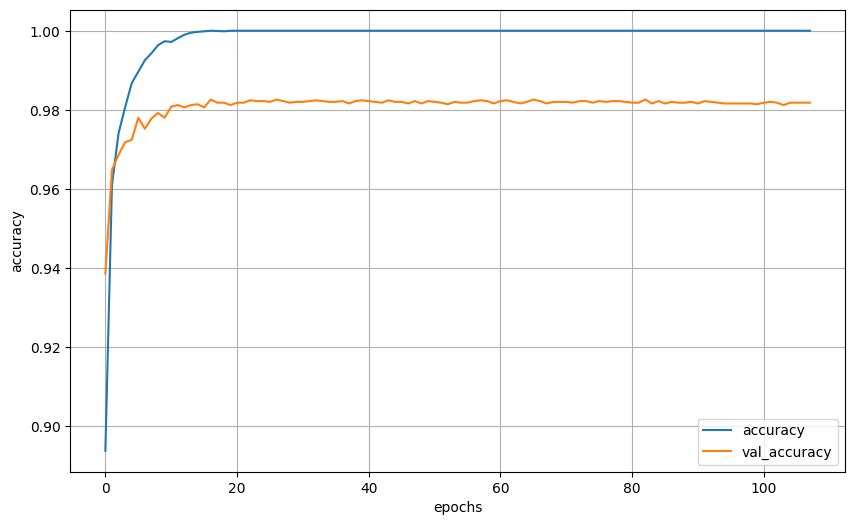

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot(figsize=(10, 6))
plt.grid(True)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [ ]:
error, accuracy, precision = network.evaluate(image_test_prep2, label_test_prep)

157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - Precision: 0.9801 - accuracy: 0.9800 - loss: 0.1627


In [ ]:
print("Error: ", error)
print("Accuracy: ", accuracy)
print("Precision: ", precision)

Error:  0.11526720970869064
Accuracy:  0.9837999939918518
Precision:  0.9839935898780823


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


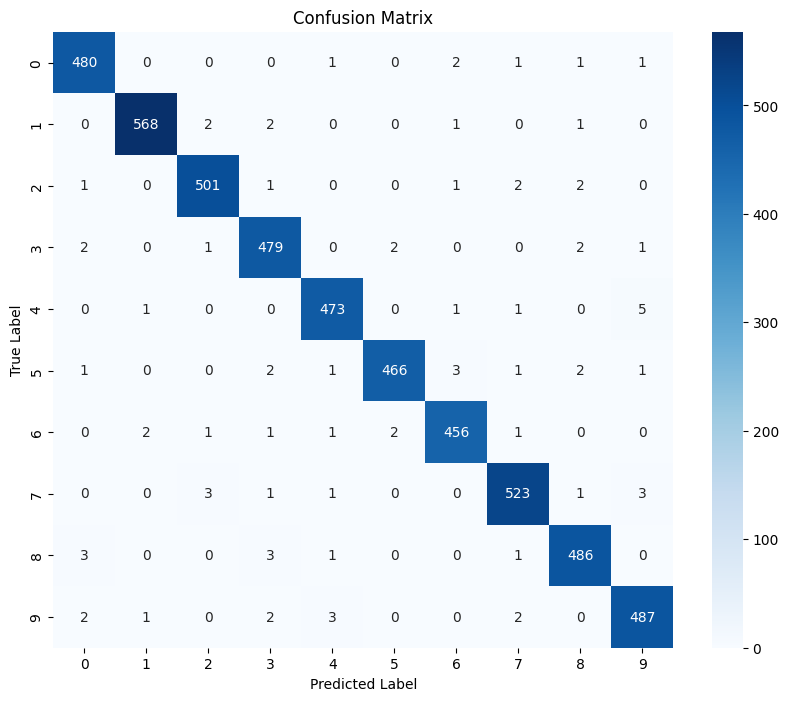

In [ ]:
# prompt: generame una matriz de confusion

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get predictions from the model
predictions = network.predict(image_test_prep2)
# Get the predicted class by finding the index of the maximum probability
predicted_classes = np.argmax(predictions, axis=1)

# Generate the confusion matrix
cm = confusion_matrix(label_test, predicted_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


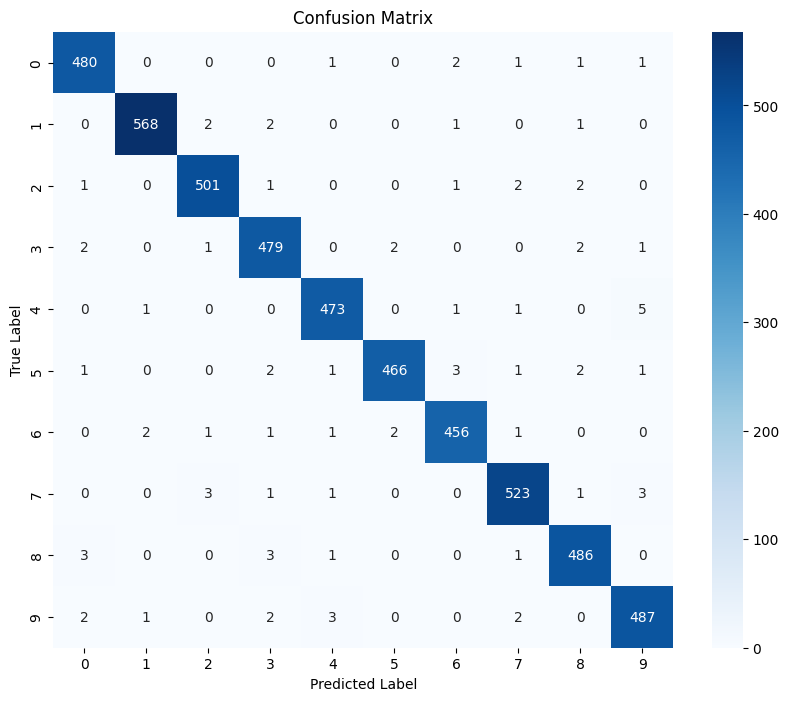

In [ ]:
# prompt: un codigo para descargar la imagen de la matriz de confusion

import matplotlib.pyplot as plt
# Save the figure
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png")
plt.show()

In [ ]:
# Guardamos el modelo en disco
network.save("modelo_aranda.keras")

Saving digitos_28x28_zip (2).zip to digitos_28x28_zip (2) (2).zip
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 452ms/step


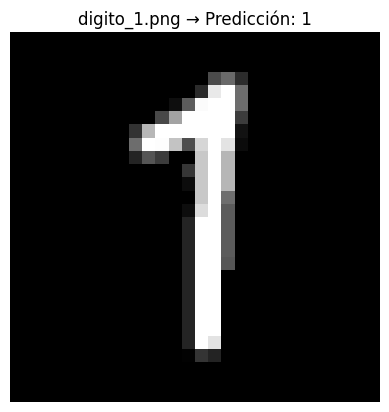

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


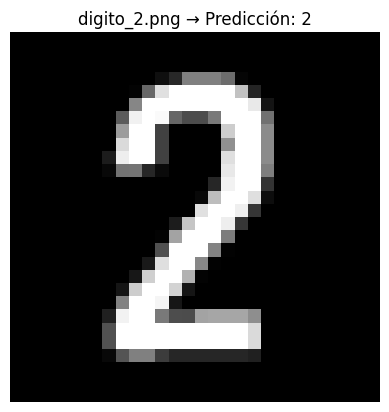

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


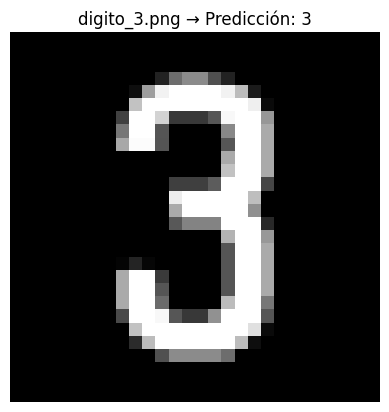

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


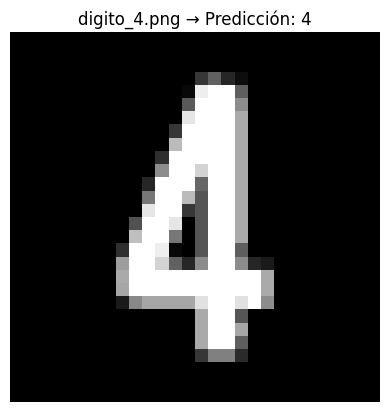

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


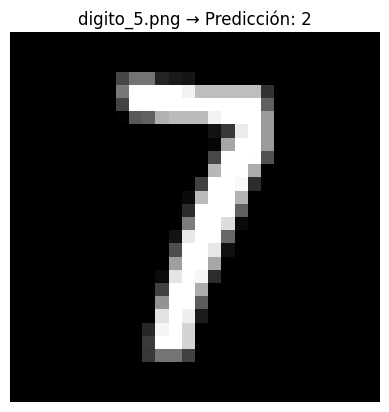

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


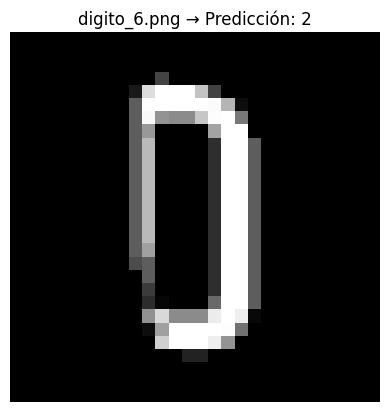

In [ ]:
# 1. Subir ZIP
from google.colab import files
uploaded = files.upload()
zip_name = list(uploaded.keys())[0]

# 2. Extraer ZIP
import zipfile
import os

extract_folder = "imagenes_extraidas"
with zipfile.ZipFile(zip_name, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# 3. Leer, preparar imágenes y predecir
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Cargar modelo previamente guardado (ajusta si es necesario)
model = load_model("/content/modelo_aranda.keras")  # Cambia la ruta si el modelo está en otro lado

# Recorrer imágenes extraídas
for archivo in sorted(os.listdir(extract_folder)):
    if archivo.lower().endswith((".png", ".jpg", ".jpeg")):
        ruta = os.path.join(extract_folder, archivo)
        img = cv2.imread(ruta, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (28, 28))
        img = img.astype("float32") / 255.0
        img_flat = img.reshape(1, 28*28)

        # Predecir
        y_proba = model.predict(img_flat)
        pred = np.argmax(y_proba, axis=-1)[0]

        # Mostrar
        plt.imshow(img, cmap="gray")
        plt.title(f"{archivo} → Predicción: {pred}")
        plt.axis("off")
        plt.show()